# Analysis and merge of climate, land and biodiversity datasets

The description of this notebook is based on the data retrieved from France, similar assumptions can be done for ***

In [2]:
import os
import sys
import cdsapi
import netCDF4 as nc
import numpy as np
import xarray as xa
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy import stats

# If one module is missing, specify its folder path inside os.path.abspath
module_dataset = os.path.abspath(os.path.join(os.getcwd(), '..', 'Dataset'))
module_this = os.path.abspath(os.path.join(os.getcwd()))
modules = [module_dataset, module_this]

for module in modules:
    if module not in sys.path:
        sys.path.append(module)

from areas import regions
import dataset_api as api
import utils as ut

In [3]:
print("Current available regions with corresponding coordinates")
regions

Current available regions with corresponding coordinates


{'france': {'latitude': [44.4, 44.8],
  'longitude': [3.6, 4.5],
  'year': 2020,
  'month': ['07']},
 'finland': {'latitude': [67.0, 69.0],
  'longitude': [25.0, 28.0],
  'year': 2014,
  'month': ['05']}}

In [4]:
region = 'france'

lat = regions[region]['latitude']
lon = regions[region]['longitude']
# lat up - lon left - lat down - lon right
area = [lat[1], lon[0], lat[0], lon[1]]


## Climate

The climate dataset has been retrieved from the ERA5 dataset, it has a 0.1° precision and all features are numerical. To facilitate our future work, we're going to multiply the latitude and longitude by 100 and transform them to integer 

In [129]:
folder = '.'
get_average_year = True
if(get_average_year):
    climate_path = folder + '/climate/' + region + '_2012avg_climate.nc'
    df_cds = ut.get_climate_dataset(climate_path, area)
else:
    year =  regions[region]['year']
    month =  regions[region]['month']
    climate_path = folder + '/' + region + '_' + year + '_' + month + 'avg_climate.nc'
    df_cds = ut.get_climate_dataset(climate_path, area, year, month)

In [130]:
df_cds.describe()

,d2m,t2m,fal,lai_hv,lai_lv,src,skt,stl1,stl2,stl3,...,ssr,str,sp,ssrd,strd,tp,swvl1,swvl2,swvl3,swvl4
count,600.000000,600.000000,600.000000,600.000000,600.000000,6.000000e+02,600.000000,600.000000,600.000000,600.000000,...,600.00,600.000,600.000000,600.00,600.0,600.000000,600.000000,600.000000,600.000000,600.000000
mean,277.476379,282.749756,0.146789,2.272260,1.862386,9.077338e-05,282.708374,283.255463,283.202637,283.143555,...,12594369.00,-5413503.500,92325.515625,14758016.00,25888154.0,0.002875,0.341497,0.340991,0.341564,0.375005
std,5.792632,6.954235,0.031949,0.765148,1.130055,5.020412e-05,7.298852,6.931011,6.597350,5.646313,...,6104480.50,1392796.000,3693.142334,7163875.50,2745177.0,0.001867,0.060429,0.064439,0.063243,0.032020
min,263.217346,267.307251,0.089313,1.053833,0.000000,5.066395e-07,266.639648,269.660034,270.472900,273.412476,...,3053066.00,-8290236.000,86843.687500,4183089.00,19096374.0,0.000012,0.161057,0.147308,0.174957,0.294357
25%,273.438789,277.617393,0.129277,1.608564,0.656927,5.186048e-05,277.042564,277.471817,277.794678,278.298012,...,7181988.75,-6657349.875,89117.812500,8602743.25,23886381.5,0.001224,0.309262,0.314305,0.304024,0.355180
50%,278.829956,282.976425,0.142058,2.174912,2.247245,8.790900e-05,282.593842,283.103989,283.003189,282.779083,...,12920257.00,-5281537.750,90838.726562,15176905.00,26539122.0,0.002634,0.358475,0.360199,0.352976,0.375939
75%,282.398964,288.234016,0.154650,2.866751,2.843962,1.263953e-04,288.579689,288.749413,288.218506,287.620277,...,18619780.50,-4261555.625,95607.861328,22002600.50,27972971.0,0.004582,0.383251,0.384571,0.393139,0.391343
max,285.752014,297.485596,0.303817,4.252808,3.405884,2.123117e-04,298.656494,299.065186,298.439209,296.213379,...,22621720.00,-2842600.000,99295.562500,26088492.00,30857358.0,0.007297,0.474167,0.476700,0.487244,0.486359


In [131]:
df_cds.shape

(600, 22)

### Null data

As we can see, the dataset is complete and there are no null values

In [132]:
print("Are there null values? ", df_cds.isna().any().any())

Are there null values?  False


### Plotting the data

We can see how almost all datas follow a constant increse/decrease pattern with big spike caused from the transition in latitude (the indexes are ordered longitude first).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D0AED557C0>,
      dtype=object)

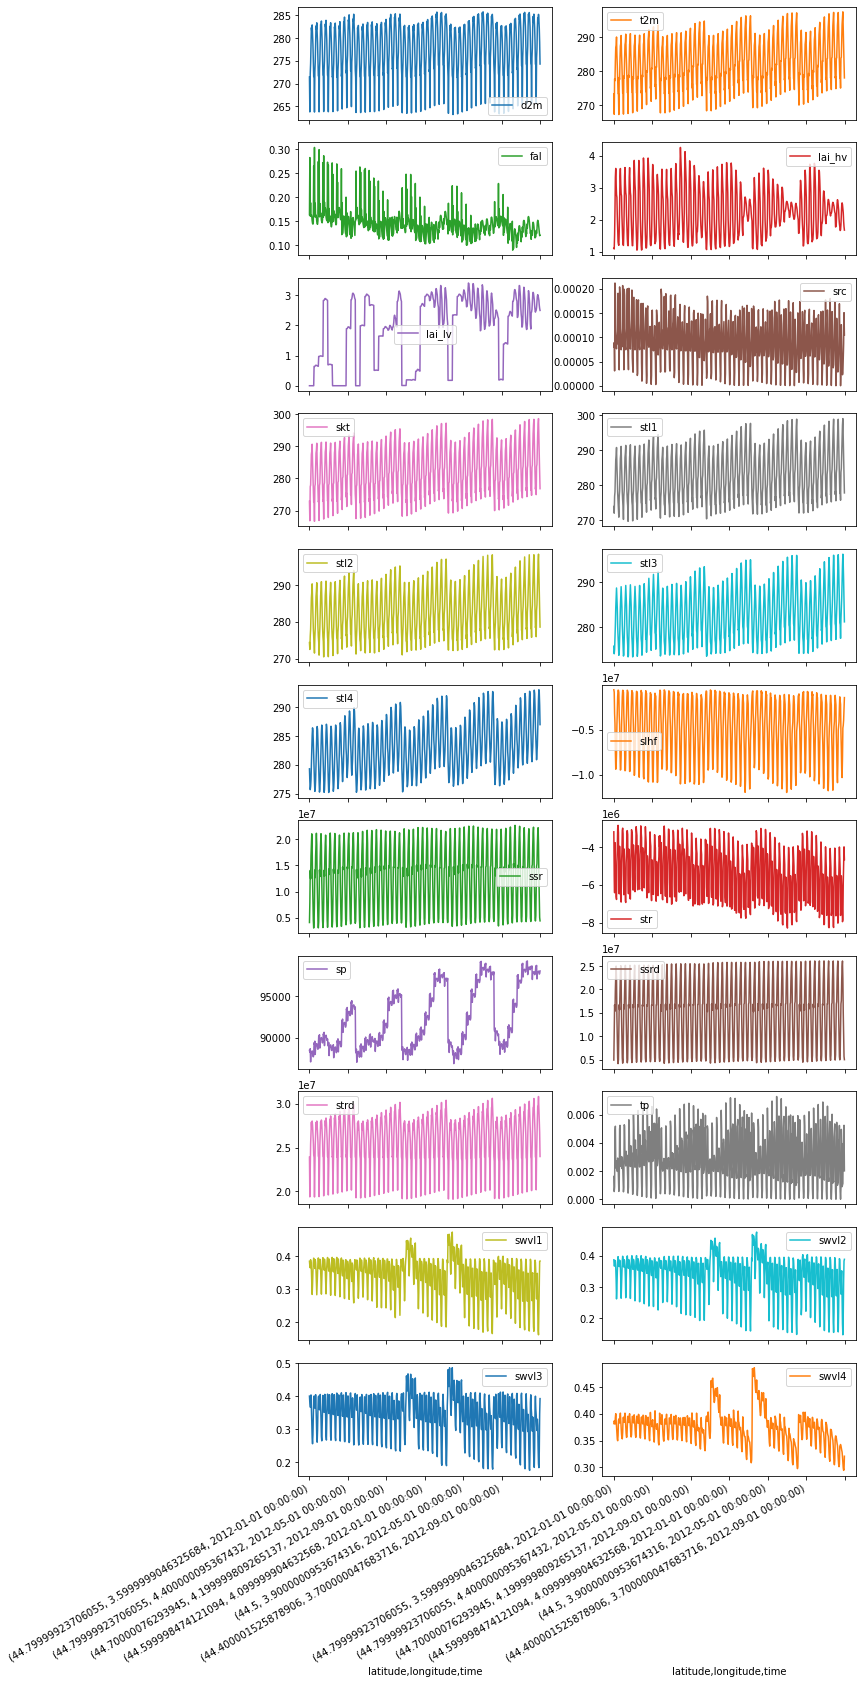

In [133]:
df_cds.plot(subplots=True, layout=(11,2), figsize=[10, 30])

## Land Dataset

The land dataset has been retrieved from the *Copernicus Land Service*, we manually checked the feature and excluded some of them.

In [5]:
land_path = './land/' + region + "_land.csv"
df_land = pd.read_csv(land_path)

In [6]:
df_land = df_land.drop(columns=['Unnamed: 0'])

# Retrieving only data of our location
df_land = df_land.loc[(df_land['latitude'] >= lat[0]) & (df_land['latitude'] <= lat[1]) 
                        & (df_land['longitude'] >= lon[0]) & (df_land['longitude'] <= lon[1])]

df_land = df_land.set_index(['longitude', 'latitude'])
#df_land.index = df_land.index.map(lambda index: (int(index[0]*100), int(index[1]*100)))

# Manually excluding features
df_land = df_land.drop(columns=['DMP300-RT0-QFLAG', 'GDMP300-RT0-QFLAG', 'FAPAR300-RT0-NOBS', 
                                'FAPAR300-RT0-LENGTH-AFTER','FAPAR300-RT0-QFLAG', 'FAPAR300-RT0-RMSE',
                               'FAPAR300-RT0-LENGTH-BEFORE', 'FCOVER300-RT0-QFLAG','FCOVER300-RT0-LENGTH-AFTER',
                                'FCOVER300-RT0-NOBS', 'FCOVER300-RT0-LENGTH-BEFORE','FCOVER300-RT0-RMSE', 
                               'LAI300-RT0-LENGTH-BEFORE','LAI300-RT0-LENGTH-AFTER', 'LAI300-RT0-NOBS',
                                'LAI300-RT0-RMSE', 'LAI300-RT0-QFLAG','SWI1km-QFLAG-015', 'SWI1km-QFLAG-020',
                                'SWI1km-QFLAG-060', 'SWI1km-QFLAG-010', 'SWI1km-SSF',
                                'SWI1km-QFLAG-005', 'SWI1km-QFLAG-100', 'SWI1km-QFLAG-040',
                                'SWI1km-QFLAG-002', 'SSM1km-ssm-noise', 'LST-Q-FLAGS', 
                                'LST-PERCENT-PROC-PIXELS', 'LST-ERRORBAR-LST','LST-TIME-DELTA',
                               'ALDH-AL-DH-QFLAG', 'ALDH-NMOD', 'ALDH-LMK', 'ALDH-AL-DH-BB-ERR',
                                'ALDH-AL-DH-VI-ERR', 'ALDH-AL-DH-NI-ERR', 'ALBH-LMK',
                                'ALBH-NMOD', 'ALBH-AL-BH-QFLAG','ALBH-AL-BH-BB-ERR', 
                                'ALBH-AL-BH-VI-ERR', 'ALBH-AL-BH-NI-ERR', 
                               'TOCR-TOCR-QFLAG', 'TOCR-NMOD','TOCR-REF-NOR-SWIR-ERR', 
                                'TOCR-REF-NOR-RED-ERR','TOCR-REF-NOR-BLUE-ERR', 'TOCR-SZN',
                                'TOCR-REF-NOR-NIR-ERR', 'BA300-FDOB-DEKAD', 'BA300-BA-DEKAD',
                                'BA300-FDOB-SEASON', 'BA300-CP-DEKAD', 'SSM1km-ssm'], errors='ignore')

# Temporary removing untile further notice
df_land = df_land.drop(columns=['DMP300-RT0-DMP'], errors='ignore')


In [7]:
df_land.isna().sum()

NDVI                       0
ALBH-AL-BH-NI              0
ALBH-AL-BH-VI              0
ALBH-AL-BH-BB              0
ALDH-AL-DH-BB              0
ALDH-AL-DH-NI              0
FAPAR300-RT0-FAPAR         0
GDMP300-RT0-GDMP           0
LST-LST                 3542
LAI300-RT0-LAI             0
SWI1km-SWI-002             0
SWI1km-SWI-100             0
SWI1km-SWI-040             0
SWI1km-SWI-005             0
SWI1km-SWI-010             0
SWI1km-SWI-060             0
SWI1km-SWI-015             0
SWI1km-SWI-020             0
TOCR-REF-NOR-BLUE          0
TOCR-REF-NOR-NIR           0
TOCR-REF-NOR-SWIR          0
TOCR-REF-NOR-RED           0
VCI_x                   3431
VCI_y                      0
FCOVER300-RT0-FCOVER       0
ALDH-AL-DH-VI              0
dtype: int64

### First observation

Before starting to clean the dataset, we have to do an observation. The choosen data span over an entire area defined by coordinates, they include both land and sea data but our job is to devine the biodiversity of land areas, in particular forest.

To remove seas data we can use the *GDMP300-RT0-GDMP* columns whose value are set to less than 0 for sea data.

In [7]:
if('GDMP300-RT0-GDMP' in df_land.columns):
    print("number of sea data: ", (df_land['GDMP300-RT0-GDMP'] < 0).sum())
    df_land = df_land[df_land['GDMP300-RT0-GDMP'] != -2]

### Null values

By counting the null values for each column we can see that some of them are null in almost all of our dataset.

In [8]:
df_land_null_cols = df_land.isnull().sum()
print("Unique number of null values per columns: ", df_land_null_cols.unique())
print("Number of columns with null count >= 3000: ", len(df_land_null_cols[df_land_null_cols >= 15000].index))

null_cols = df_land_null_cols[df_land_null_cols >= 3000].index
print("Columns with mostly null values: ", null_cols)
df_land = df_land.drop(columns=null_cols)

Unique number of null values per columns:  [     0 304690    800 295712]
Number of columns with null count >= 3000:  2
Columns with mostly null values:  Index(['LST-LST', 'VCI_y'], dtype='object')


We check for other null values

In [22]:
print("Are there null values? ", df_land.isna().sum())

Are there null values?  NDVI                 0
ALBH-AL-BH-BB        0
ALBH-AL-BH-NI        0
ALBH-AL-BH-VI        0
ALDH-AL-DH-BB        0
ALDH-AL-DH-NI        0
ALDH-AL-DH-VI        0
DMP-RT6-DMP          0
FAPAR300-FAPAR       0
FCOVER300-FCOVER     0
GDMP300-RT5-GDMP     0
LAI300-LAI           0
SWI1km-SWI-020       0
SWI1km-SWI-040       0
SWI1km-SWI-060       0
SWI1km-SWI-100       0
SWI1km-SWI-002       0
SWI1km-SWI-005       0
SWI1km-SWI-010       0
SWI1km-SWI-015       0
TOCR-REF-NOR-BLUE    0
TOCR-REF-NOR-NIR     0
TOCR-REF-NOR-RED     0
TOCR-REF-NOR-SWIR    0
VCI_x                0
dtype: int64


### Handle outliers and wrong values

Firstly we plot the different features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D0BB7DE5B0>,
      dtype=object)

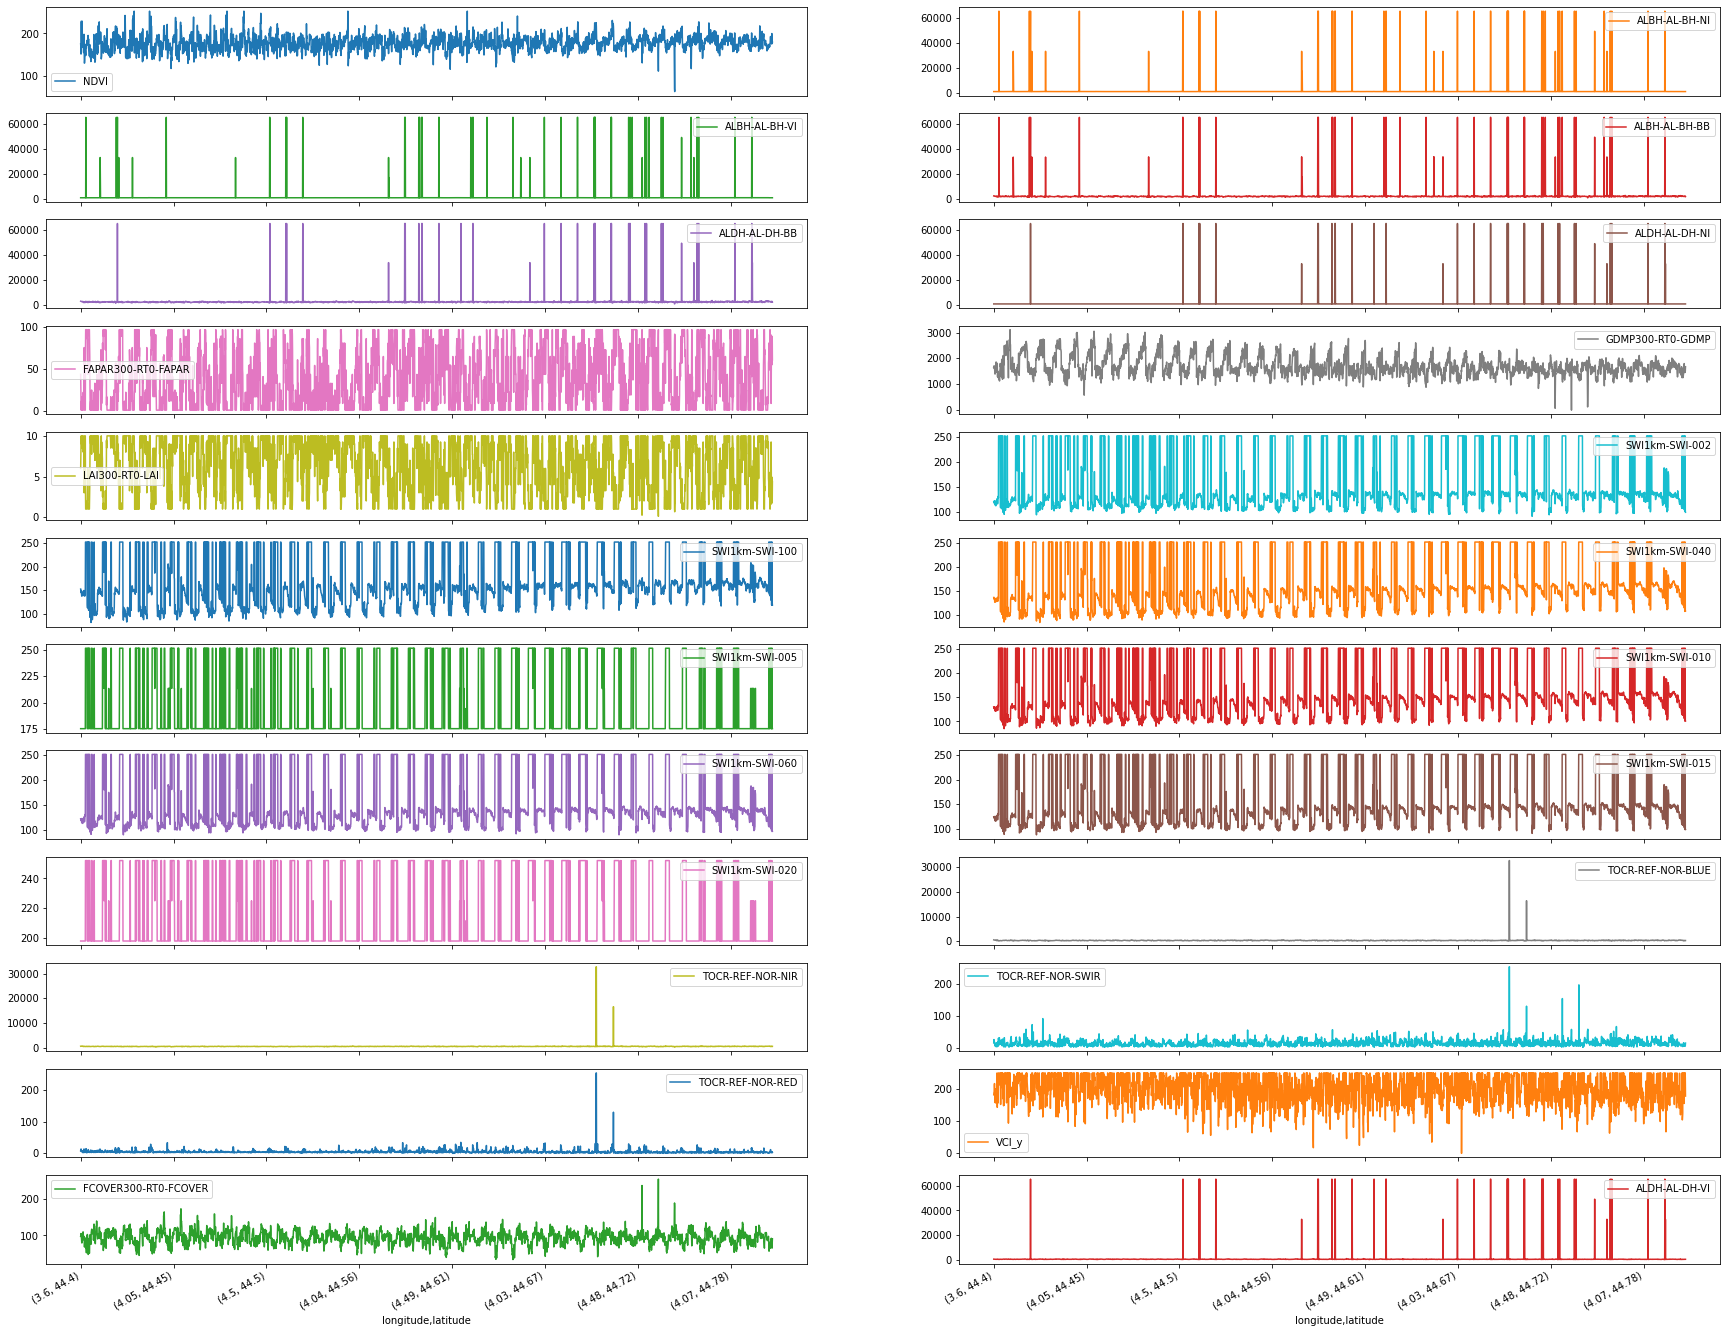

In [140]:
df_land.plot(subplots=True, layout=(14,2), figsize=(30,30))

In [141]:
df_land.columns

Index(['NDVI', 'ALBH-AL-BH-NI', 'ALBH-AL-BH-VI', 'ALBH-AL-BH-BB',
       'ALDH-AL-DH-BB', 'ALDH-AL-DH-NI', 'FAPAR300-RT0-FAPAR',
       'GDMP300-RT0-GDMP', 'LAI300-RT0-LAI', 'SWI1km-SWI-002',
       'SWI1km-SWI-100', 'SWI1km-SWI-040', 'SWI1km-SWI-005', 'SWI1km-SWI-010',
       'SWI1km-SWI-060', 'SWI1km-SWI-015', 'SWI1km-SWI-020',
       'TOCR-REF-NOR-BLUE', 'TOCR-REF-NOR-NIR', 'TOCR-REF-NOR-SWIR',
       'TOCR-REF-NOR-RED', 'VCI_y', 'FCOVER300-RT0-FCOVER', 'ALDH-AL-DH-VI'],
      dtype='object')

#### Albedo

For the albedo features (*ALBH* ans *ALDH*) the maximum value should be 10000 and some specif values are used:

- 65535 for invalid values
- 65534 for values with out of range value inferior to the minimum physical value
- 65533 for values with out of range value superior to the max physical value

To align the values we will firstly set 65534 to 0, 65533 and every other value greater than 10000 to 10000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026F3636AEB0>,
      dtype=object)

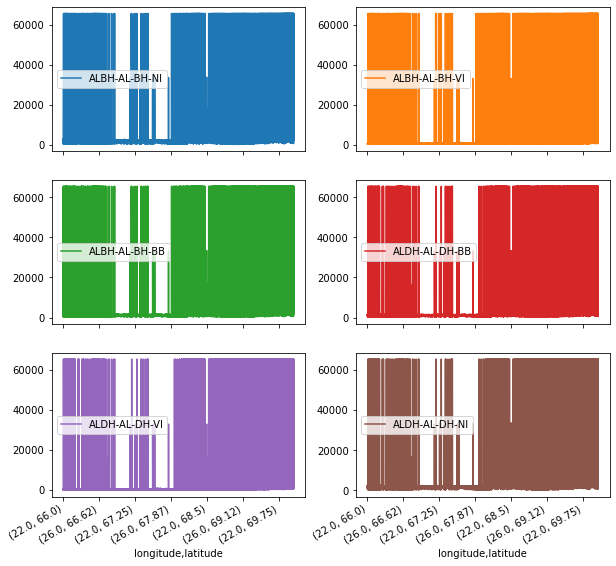

In [17]:
albedo_labels = ['ALBH-AL-BH-NI', 'ALBH-AL-BH-VI', 'ALBH-AL-BH-BB',
       'ALDH-AL-DH-BB', 'ALDH-AL-DH-VI', 'ALDH-AL-DH-NI']

df_land[albedo_labels].plot(subplots=True, layout=(3,2), figsize=(10,10))

In [21]:
df_land[df_land[albedo_labels] > 10000][albedo_labels].count()


ALBH-AL-BH-NI    41626
ALBH-AL-BH-VI    41626
ALBH-AL-BH-BB    41626
ALDH-AL-DH-BB    41153
ALDH-AL-DH-VI    41153
ALDH-AL-DH-NI    41153
dtype: int64

In [23]:

df_land_albedo = df_land[albedo_labels].copy()

df_land_albedo[df_land_albedo == 65534] = 0
df_land_albedo[df_land_albedo > 10000] = 10000

df_land_albedo.describe()

,ALBH-AL-BH-NI,ALBH-AL-BH-VI,ALBH-AL-BH-BB,ALDH-AL-DH-BB,ALDH-AL-DH-VI,ALDH-AL-DH-NI
count,80800.000000,80800.000000,80800.000000,80800.00000,80800.000000,80800.000000
mean,1878.033617,440.093707,1279.203014,1211.98224,403.884335,1786.813283
std,820.238572,905.198643,845.130553,703.03323,744.321223,693.576937
min,223.000000,37.000000,170.000000,149.00000,73.000000,180.000000
25%,1717.000000,319.500000,1142.000000,1114.00000,314.500000,1669.000000
50%,1858.000000,357.000000,1234.500000,1191.00000,347.000000,1790.000000
75%,1974.000000,395.000000,1312.000000,1259.00000,381.000000,1891.000000
max,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000


To detect the outliers we will use the quartile and interquartile range and define a value as outliers if $z_{score} > 3$ 

Count of outliers:

In [143]:
mask = (np.abs(stats.zscore(df_land_albedo)) > 3)

df_land_albedo[mask] = None
df_land_albedo.isna().sum()

ALBH-AL-BH-NI    61
ALBH-AL-BH-VI    61
ALBH-AL-BH-BB    61
ALDH-AL-DH-BB    44
ALDH-AL-DH-VI    44
ALDH-AL-DH-NI    44
dtype: int64

Now that we know what are the outliers, we can correct them by taking the average of the 4 closest coordinates

In [13]:
df_land_albedo.fillna(df_land_albedo.mean(), inplace=True)
#for col in albedo_labels:
#    df_land_albedo[col] = utils.mean_of_closest_point(df_land_albedo[col], 0.01, area, df_land_albedo[col].mean())

NameError: name 'df_land_albedo' is not defined

,ALBH-AL-BH-NI,ALBH-AL-BH-VI,ALBH-AL-BH-BB,ALDH-AL-DH-BB,ALDH-AL-DH-VI,ALDH-AL-DH-NI
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,1212.140041,969.588813,1870.146044,2469.562398,308.954101,955.464761
std,19.311034,12.587783,199.971115,276.614037,88.264566,7.152291
min,1187.000000,954.000000,790.500000,874.500000,73.000000,949.000000
25%,1199.000000,962.000000,1746.000000,2289.000000,251.250000,951.000000
50%,1205.000000,965.000000,1870.146044,2470.000000,294.000000,953.000000
75%,1218.000000,973.000000,1994.000000,2650.000000,351.000000,957.000000
max,1288.000000,1020.000000,2681.000000,3640.000000,853.000000,993.000000


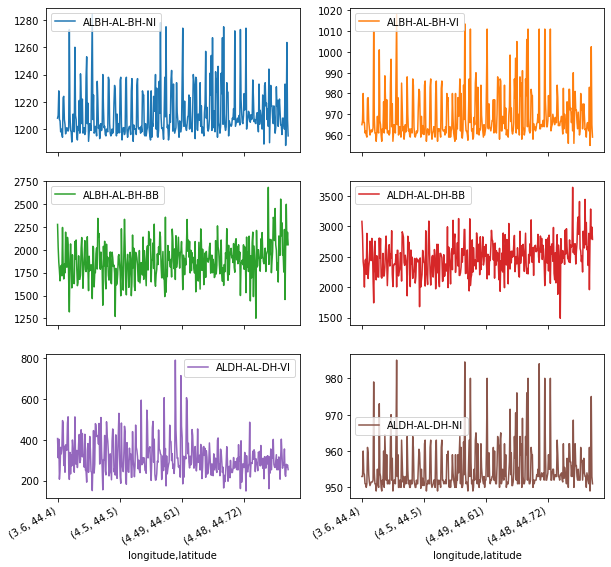

In [145]:
df_land_albedo[::10].plot(subplots=True, layout=(3,2), figsize=(10,10))
df_land_albedo.describe()

The *ALDH-AL-DH-VI* has a strange range of values despite using the same unit of measure as the others albedo variables. We're going to keep it and assume the data have been scaled.

#### TOC Reflectance

Top-Of-Canopy (TOC) spectral reflectance quantifies the fraction of the sunlight reflected by the surface of the Earth, in a given spectral band. The physical max value is 1.2 and is transposed in a (0, 2400) range.

As we did for the albedo, we're going to explore the data to find outliers and adjust the specific values. In this case the invalid values are set to 32767

In [24]:
tocr_labels = ['TOCR-REF-NOR-BLUE', 'TOCR-REF-NOR-NIR', 'TOCR-REF-NOR-SWIR', 'TOCR-REF-NOR-RED']

df_land_tocr = df_land[tocr_labels].copy()

In [147]:
df_land_tocr[df_land_tocr > 2400] = None
mask = (np.abs(stats.zscore(df_land_tocr)) > 3)
df_land_tocr[mask] = None
print(df_land_tocr.isna().sum())

#df_land_tocr.fillna(df_land_tocr.mean(), inplace=True)
for col in tocr_labels:
    df_land_tocr[col] = utils.mean_of_closest_point(df_land_tocr[col], 0.01, area, df_land_tocr[col].mean())

df_land_tocr.describe()

<ipython-input-147-88e2e1596cfc>:2: RuntimeWarning: invalid value encountered in greater
  mask = (np.abs(stats.zscore(df_land_tocr)) > 3)


TOCR-REF-NOR-BLUE     3
TOCR-REF-NOR-NIR      3
TOCR-REF-NOR-SWIR    24
TOCR-REF-NOR-RED     21
dtype: int64


,TOCR-REF-NOR-BLUE,TOCR-REF-NOR-NIR,TOCR-REF-NOR-SWIR,TOCR-REF-NOR-RED
count,3726.000000,3726.000000,3726.000000,3726.000000
mean,377.808232,490.252489,14.013438,4.907587
std,76.915556,54.147813,8.104899,3.698647
min,154.000000,177.500000,2.000000,0.000000
25%,324.000000,455.500000,8.000000,3.000000
50%,375.000000,487.000000,12.000000,4.000000
75%,429.875000,522.687500,19.000000,5.500000
max,644.000000,691.000000,48.000000,27.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D0AA4EED90>,
      dtype=object)

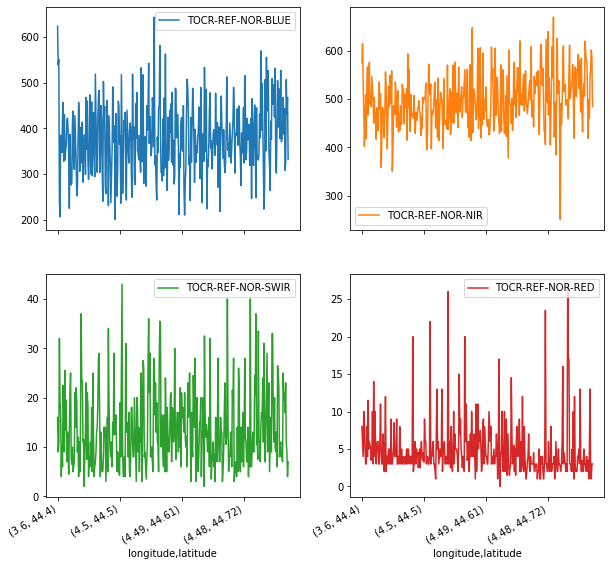

In [148]:
df_land_tocr[::10].plot(subplots=True, layout=(2,2), figsize=(10,10))

#### SWI

For Soil Water Index the values should be in a range (0, 200) and 255 is used for errors. A third of the values are greater than 200

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001707D684280>,
      dtype=object)

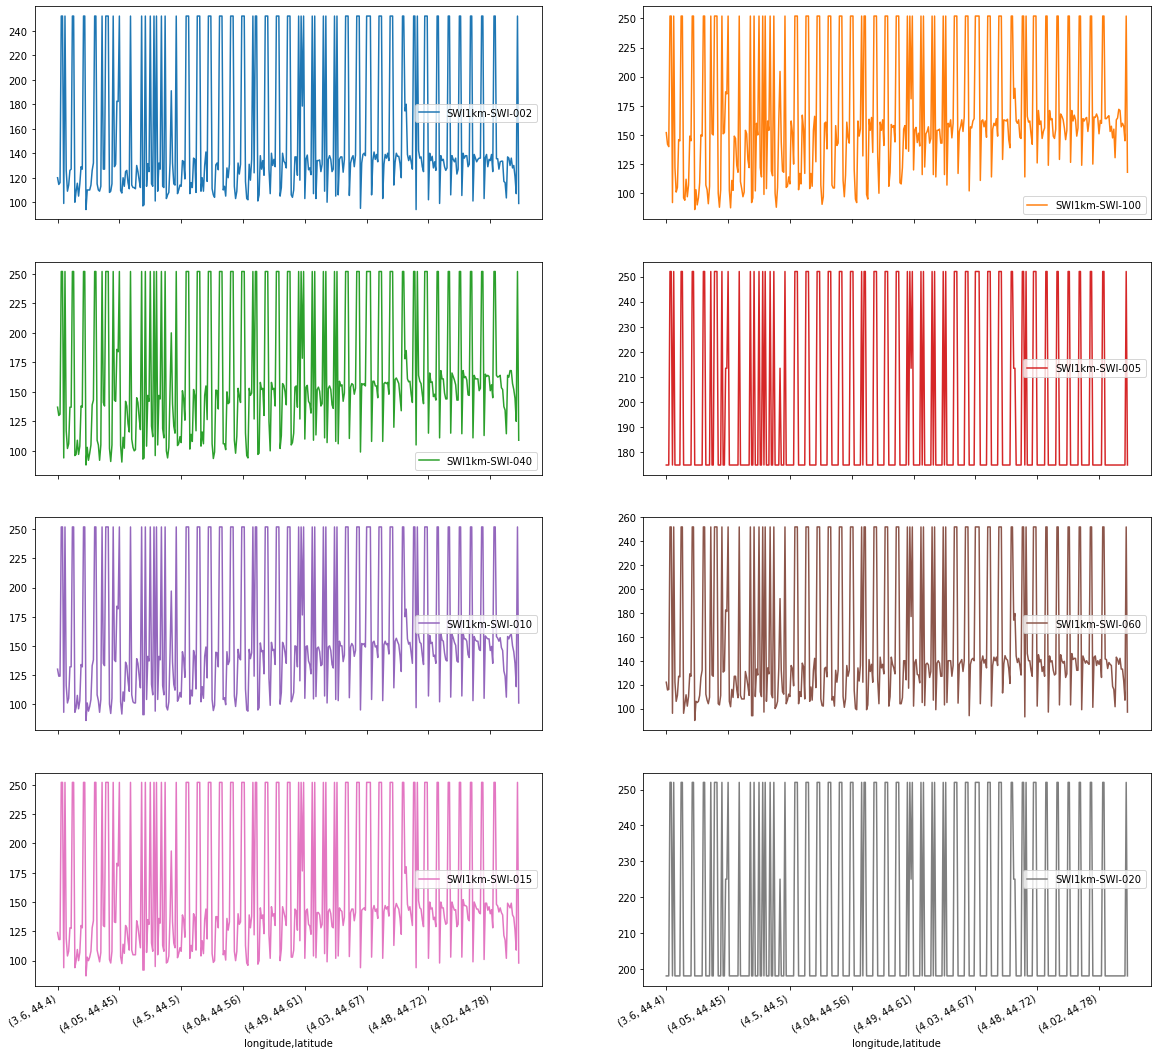

In [9]:
swi_labels = ['SWI1km-SWI-002', 'SWI1km-SWI-100',
       'SWI1km-SWI-040', 'SWI1km-SWI-005', 'SWI1km-SWI-010', 'SWI1km-SWI-060',
       'SWI1km-SWI-015', 'SWI1km-SWI-020']

df_land[swi_labels][::10].plot(subplots=True, layout=(4,2), figsize=(20,20))

In [10]:
swi_labels = ['SWI1km-SWI-002', 'SWI1km-SWI-100',
       'SWI1km-SWI-040', 'SWI1km-SWI-005', 'SWI1km-SWI-010', 'SWI1km-SWI-060',
       'SWI1km-SWI-015', 'SWI1km-SWI-020']

df_land_swi = df_land[swi_labels].copy()
for col in swi_labels:
    df_land_swi[df_land_swi[col] >= 200] = None


In [11]:
df_land_swi.isna().sum()

SWI1km-SWI-002    1083
SWI1km-SWI-100    1083
SWI1km-SWI-040    1083
SWI1km-SWI-005    1083
SWI1km-SWI-010    1083
SWI1km-SWI-060    1083
SWI1km-SWI-015    1083
SWI1km-SWI-020    1083
dtype: int64

In [11]:
df_land[df_land[swi_labels] >= 200].count()

NDVI                    0
ALBH-AL-BH-BB           0
ALBH-AL-BH-NI           0
ALBH-AL-BH-VI           0
ALDH-AL-DH-BB           0
ALDH-AL-DH-NI           0
ALDH-AL-DH-VI           0
DMP-RT6-DMP             0
FAPAR300-FAPAR          0
FCOVER300-FCOVER        0
GDMP300-RT5-GDMP        0
LAI300-LAI              0
SWI1km-SWI-060       6936
SWI1km-SWI-100       6888
SWI1km-SWI-010       7437
SWI1km-SWI-015       7383
SWI1km-SWI-020       7357
SWI1km-SWI-040       7314
SWI1km-SWI-002       8231
SWI1km-SWI-005       7533
TOCR-REF-NOR-BLUE       0
TOCR-REF-NOR-NIR        0
TOCR-REF-NOR-RED        0
TOCR-REF-NOR-SWIR       0
VCI_x                   0
dtype: int64

In [55]:

#mask = (np.abs(stats.zscore(df_land_swi)) > 3)
#df_land_swi[mask] = None

#df_land_swi.fillna(df_land_swi.mean(), inplace=True)
for col in swi_labels:
    df_land_swi[col] = utils.mean_of_closest_point(df_land_swi[col], 0.01, area, df_land_swi[col].mean())

df_land_swi[::10].plot(subplots=True, layout=(4,2), figsize=(20,20))
df_land_swi.describe()

KeyboardInterrupt: 

#### Other columns

Other columns are fine and don't need to be preprocessed

,NDVI,FAPAR300-RT0-FAPAR,GDMP300-RT0-GDMP,LAI300-RT0-LAI,VCI_y,FCOVER300-RT0-FCOVER
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,177.613763,38.351762,1713.957167,6.496090,199.779321,94.840190
std,17.346144,34.655369,384.382395,3.251110,41.808644,18.247453
min,64.500000,1.000000,-1.777778,0.111111,0.000000,33.833333
25%,166.703125,1.000000,1454.166667,3.812500,171.000000,83.557292
50%,177.111111,33.000000,1636.875000,7.000000,201.000000,95.222222
75%,188.333333,67.000000,1902.145833,10.000000,241.500000,106.333333
max,252.000000,97.000000,3112.222222,10.000000,250.000000,255.000000


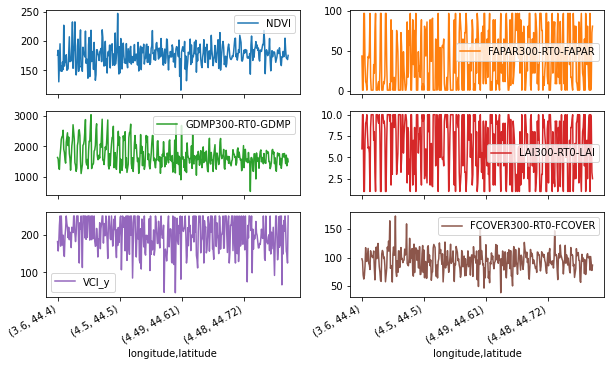

In [151]:
df_land_other = df_land.drop(columns=albedo_labels + tocr_labels + swi_labels)
df_land_other[::10].plot(subplots=True, layout=(5,2), figsize=(10,10))
df_land_other.describe()

In [23]:
df_land[albedo_labels] = df_land_albedo
df_land[tocr_labels] = df_land_tocr
df_land[swi_labels] = df_land_swi

In [26]:
df_land.shape

(80800, 25)

## Merge of Climate and Land dataset

In [27]:
def distance(lon1, lon2, lat1, lat2):
    return np.sqrt((lon1-lon2)**2 + (lat1-lat2)**2)

df1 = df_cds.reset_index()
df2 = df_land.reset_index()

minimum = [-1] * df2.shape[0]
coords_y = df1.values[:, 0:2]
for i, [lon_x, lat_x] in enumerate(df2.values[:, 0:2]):
    distances = list(map(lambda coord_y: distance(lon_x, coord_y[0], lat_x, coord_y[1]), coords_y))
    minimum[i] = np.argmin(distances)

df1.drop(columns=['longitude', 'latitude'], inplace=True)
df2['merge_index'] = minimum
df = df2.merge(df1, left_on='merge_index', right_index=True).drop(columns=['merge_index'])
df.set_index(['longitude', 'latitude'], inplace=True)

NameError: name 'df_cds' is not defined

## Add biodiversity index

The habitat richness values have a range of (0, 1) 
The dataset has been created using a mask to exclude non forest area that are represented as values less equal than 0

In [4]:
df_richness = pd.read_csv('./richness/EEA_richness_latLon_finland.csv').drop(columns=['Unnamed: 0'])


In [6]:
df_richness = df_richness.loc[(df_richness['latitude'] >= lat[0]) & (df_richness['latitude'] <= lat[1]) 
                        & (df_richness['longitude'] >= lon[0]) & (df_richness['longitude'] <= lon[1])]

In [9]:
df_richness[df_richness.habitat_richness > 0].count()

habitat_richness    52498
longitude           52498
latitude            52498
dtype: int64

In [25]:
df_richness = df_richness[df_richness.habitat_richness > 0]
df_richness.set_index(['longitude', 'latitude'], inplace=True)

df_final = df_richness.merge(df, left_index=True, right_index=True)

In [26]:
df_richness[df_richness['habitat_richness'] > 0].describe()

,habitat_richness
count,2024.000000
mean,0.328586
std,0.063279
min,0.167757
25%,0.278481
50%,0.330319
75%,0.369739
max,0.566262


In [27]:
df_final

habitat_richness        NDVI  ALBH-AL-BH-NI  \
longitude latitude                                                
3.6       44.43             0.419306  161.000000         1273.0   
          44.44             0.413982  182.166667         1268.0   
          44.45             0.413982  185.666667         1214.0   
          44.46             0.413982  176.777778         1213.0   
          44.47             0.419306  161.166667         1235.0   
...                              ...         ...            ...   
4.5       44.76             0.340203  188.083333         1209.5   
          44.76             0.340203  188.083333         1209.5   
          44.77             0.340203  180.125000         1217.0   
          44.78             0.340203  176.416667         1219.0   
          44.79             0.340203  168.750000         1211.5   

                    ALBH-AL-BH-VI  ALBH-AL-BH-BB  ALDH-AL-DH-BB  \
longitude latitude                                                
3.6       44.43            1011.0         1407.0         1821.0   
          44.44            1007.0         1415.0         1799.0   
          44.45             971.0         1441.0         1873.0   
          44.46             971.0         1594.0         1881.0   
          44.47             985.0         1507.0         1962.0   
...                           ...            ...            ...   
4.5       44.76             967.5         1686.5         2231.0   
          44.76             967.5         1686.5         2231.0   
          44.77             971.5         1739.5         2359.0   
          44.78             973.0         1855.0         2568.0   
          44.79             968.0         1815.0         2431.5   

                    ALDH-AL-DH-NI  FAPAR300-RT0-FAPAR  GDMP300-RT0-GDMP  \
longitude latitude                                                        
3.6       44.43             980.0           33.000000       1492.333333   
          44.44             978.0           33.000000       1545.416667   
          44.45             955.0           11.666667       1674.888889   
          44.46             955.0           22.333333       1559.222222   
          44.47             962.0           81.000000       1378.083333   
...                           ...                 ...               ...   
4.5       44.76             954.5           97.000000       1586.833333   
          44.76             954.5           97.000000       1586.833333   
          44.77             956.5           73.000000       1631.312500   
          44.78             957.0            1.000000       1662.000000   
          44.79             955.0           81.000000       1531.416667   

                    LAI300-RT0-LAI  ...         ssr        str            sp  \
longitude latitude                  ...                                        
3.6       44.43               7.00  ...  12441340.0 -5370235.5  90567.507812   
          44.44               7.00  ...  12441340.0 -5370235.5  90567.507812   
          44.45               9.00  ...  12441340.0 -5370235.5  90567.507812   
          44.46               8.00  ...  12483643.0 -5230864.5  89168.343750   
          44.47               2.50  ...  12483643.0 -5230864.5  89168.343750   
...                            ...  ...         ...        ...           ...   
4.5       44.76               1.00  ...  12537616.0 -5251764.0  93807.460938   
          44.76               1.00  ...  12537616.0 -5251764.0  93807.460938   
          44.77               3.25  ...  12537616.0 -5251764.0  93807.460938   
          44.78              10.00  ...  12537616.0 -5251764.0  93807.460938   
          44.79               2.50  ...  12537616.0 -5251764.0  93807.460938   

                          ssrd        strd        tp     swvl1     swvl2  \
longitude latitude                                                         
3.6       44.43     14720521.0  25503226.0  0.002537  0.336990  0.338934   
          44.44     14720521.0 

In [28]:
df_final.to_csv('../Dataset/france.csv')